In [1]:
from __future__ import print_function
from os.path import join
import time

import numpy as np
import pandas as pd
import pyxis as px
from astropy.io import fits
import matplotlib.pyplot as plt

#### Find range of noise to normalize over

In [12]:
n = 4000
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data_low_g/'
mins = np.empty((100000,), dtype=np.float64)
maxs = np.empty((100000,), dtype=np.float64)
for index in range(5):
    folder = index+1
    start_id = index*n
    for i in range(n):
        ID = start_id + i
        with fits.open(join(data_dir, f'temp_{folder}/testing_{ID}.fits')) as hdu:
            data = np.concatenate((hdu[1].data + hdu[2].data, hdu[3].data + hdu[4].data, hdu[5].data + hdu[6].data))
            mins[ID] = np.min(data)
            maxs[ID] = np.max(data)
    print(f'Folder {folder} complete')

Folder 1 complete
Folder 2 complete
Folder 3 complete
Folder 4 complete
Folder 5 complete
Folder 6 complete
Folder 7 complete
Folder 8 complete
Folder 9 complete
Folder 10 complete
Folder 11 complete
Folder 12 complete
Folder 13 complete
Folder 14 complete
Folder 15 complete
Folder 16 complete
Folder 17 complete
Folder 18 complete
Folder 19 complete
Folder 20 complete
Folder 21 complete
Folder 22 complete
Folder 23 complete
Folder 24 complete
Folder 25 complete


In [15]:
total = np.concatenate((maxs, mins))
print(np.min(total))
print(np.max(total))

-179.40306021006285
184.83903049721658


### Start here to create database

In [2]:
def normalize(samples):
    for par, values in samples.items():
        if par in par_ranges.keys():
            low, high = par_ranges[par]
            values -= low
            values /= high-low

In [3]:
def add_noise(data, SNR):
    noise = np.random.normal(0, 1, data.shape)
    segmask = data > 0.1*np.max(data)
    target = np.sum(data[segmask])/SNR
    noise *= target/np.sqrt(np.sum(noise[segmask]**2))
    return data + noise

In [4]:
par_ranges = \
{
    'g1': [-0.1, 0.1],
    'g2': [-0.1, 0.1],
}

img_noise_range = [-100, 150]
spec_noise_range = [-250, 250]

In [5]:
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data_low_g/'
with fits.open(join(data_dir, f'temp_{1}/training_{0}.fits')) as hdu:

    img = hdu[7].data
    img_wnoise = add_noise(img, 15)

    specs = np.full((3, 64), 0.)
    for j in range(3):
        spec = hdu[2*j+1].data
        spec_wnoise = add_noise(spec, 15)
        specs[j, :spec.shape[0]] = spec_wnoise

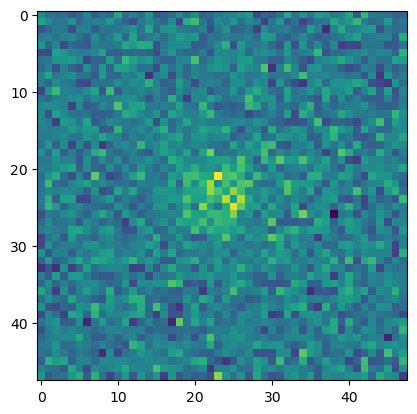

In [6]:
plt.imshow(img_wnoise)

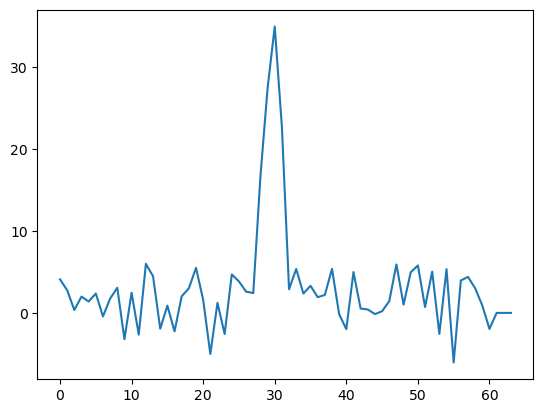

In [7]:
plt.plot(specs[0])

### Create training database

In [ ]:
n = 4000
nreal = 1
SNR = [50]
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data/'
samp_dir = '/xdisk/timeifler/wxs0703/kl_nn/samples/samples_train_low_g_1m.csv'
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data/train_database_SNR50'
samples = pd.read_csv(samp_dir)
normalize(samples)

#minmax = np.full((50, 4), 0.)

with px.Writer(dirpath=save_dir, map_size_limit=200000, ram_gb_limit=8) as db:
    
    for index in range(250):
        start = time.time()
        folder = index+1
        img_stack = np.full((n*nreal, 1, 48, 48), 0.)
        spec_stack = np.full((n*nreal, 1, 3, 64), 0.)
        fids = np.full((n*nreal, 2), 0.)
        start_id = index*n*nreal
        file_id = index*n
        ids = np.arange(start_id, start_id+n*nreal, dtype=np.uint64)

        for i in range(n):
            
            ID = file_id + i

            with fits.open(join(data_dir, f'temp_{folder}/training_{ID}.fits')) as hdu:

                img = hdu[7].data
                for j in range(nreal):
                    img_wnoise = add_noise(img, SNR[j])
                    #low, high = img_noise_range
                    #img -= low
                    #img /= high-low
                    img_stack[i*nreal+j, 0] = img_wnoise
                    
                    specs = np.full((3, 64), 0.)
                    for k in range(3):
                        spec = hdu[2*k+1].data
                        spec_wnoise = add_noise(spec, SNR[j])
                        specs[k, :spec.shape[0]] = spec_wnoise
                    #low, high = spec_noise_range
                    #specs -= low
                    #specs /= high-low
                    spec_stack[i*nreal+j, 0] = specs

                    fids[i*nreal+j] = np.array(samples.iloc[ID])[1:3]
        
        #minmax[index] = [np.max(img_stack), np.min(img_stack), np.max(spec_stack), np.min(spec_stack)]
        #print(minmax[index])
                
        db.put_samples({'img': img_stack,
                        'spec': spec_stack,
                        'fid_pars': fids,
                        'id': ids})
        t = round(time.time() - start, 2)
        
        print(f'folder {folder} complete, {t} seconds')

#np.save('minmax_train', minmax)

folder 1 complete, 56.45 seconds
folder 2 complete, 58.79 seconds
folder 3 complete, 58.92 seconds
folder 4 complete, 57.85 seconds
folder 5 complete, 58.14 seconds
folder 6 complete, 51.0 seconds
folder 7 complete, 59.87 seconds
folder 8 complete, 62.77 seconds
folder 9 complete, 59.38 seconds
folder 10 complete, 56.66 seconds
folder 11 complete, 48.11 seconds
folder 12 complete, 48.05 seconds
folder 13 complete, 56.65 seconds
folder 14 complete, 48.11 seconds
folder 15 complete, 48.15 seconds
folder 16 complete, 57.93 seconds
folder 17 complete, 55.95 seconds
folder 18 complete, 57.56 seconds
folder 19 complete, 48.53 seconds
folder 20 complete, 60.91 seconds
folder 21 complete, 57.81 seconds
folder 22 complete, 58.78 seconds
folder 23 complete, 58.55 seconds
folder 24 complete, 47.46 seconds
folder 25 complete, 60.1 seconds
folder 26 complete, 59.29 seconds
folder 27 complete, 58.13 seconds
folder 28 complete, 58.78 seconds
folder 29 complete, 48.69 seconds
folder 30 complete, 60.36

### Create testing database

In [14]:
n = 4000
nreal = 1
SNR = [50]
data_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data/'
samp_dir = '/xdisk/timeifler/wxs0703/kl_nn/samples/samples_test_low_g_1m.csv'
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data/test_database_SNR50'
samples = pd.read_csv(samp_dir)
normalize(samples)

#minmax = np.full((50, 4), 0.)

with px.Writer(dirpath=save_dir, map_size_limit=200000, ram_gb_limit=8) as db:
    
    for index in range(25):
        start = time.time()
        folder = index+1
        img_stack = np.full((n*nreal, 1, 48, 48), 0.)
        spec_stack = np.full((n*nreal, 1, 3, 64), 0.)
        fids = np.full((n*nreal, 2), 0.)
        start_id = index*n*nreal
        file_id = index*n
        ids = np.arange(start_id, start_id+n*nreal, dtype=np.uint64)

        for i in range(n):
            
            ID = file_id + i

            with fits.open(join(data_dir, f'temp_{folder}/testing_{ID}.fits')) as hdu:

                img = hdu[7].data
                for j in range(nreal):
                    img_wnoise = add_noise(img, SNR[j])
                    #low, high = img_noise_range
                    #img -= low
                    #img /= high-low
                    img_stack[i*nreal+j, 0] = img_wnoise
                    
                    specs = np.full((3, 64), 0.)
                    for k in range(3):
                        spec = hdu[2*k+1].data
                        spec_wnoise = add_noise(spec, SNR[j])
                        specs[k, :spec.shape[0]] = spec_wnoise
                    #low, high = spec_noise_range
                    #specs -= low
                    #specs /= high-low
                    spec_stack[i*nreal+j, 0] = specs

                    fids[i*nreal+j] = np.array(samples.iloc[ID])[1:3]
        
        #minmax[index] = [np.max(img_stack), np.min(img_stack), np.max(spec_stack), np.min(spec_stack)]
        #print(minmax[index])
                
        db.put_samples({'img': img_stack,
                        'spec': spec_stack,
                        'fid_pars': fids,
                        'id': ids})
        t = round(time.time() - start, 2)
        
        print(f'folder {folder} complete, {t} seconds')

#np.save('minmax_train', minmax)

folder 1 complete, 44.66 seconds
folder 2 complete, 47.21 seconds
folder 3 complete, 45.33 seconds
folder 4 complete, 47.73 seconds
folder 5 complete, 56.02 seconds
folder 6 complete, 44.25 seconds
folder 7 complete, 45.16 seconds
folder 8 complete, 44.82 seconds
folder 9 complete, 44.11 seconds
folder 10 complete, 44.82 seconds
folder 11 complete, 54.51 seconds
folder 12 complete, 44.5 seconds
folder 13 complete, 46.01 seconds
folder 14 complete, 46.01 seconds
folder 15 complete, 45.69 seconds
folder 16 complete, 47.93 seconds
folder 17 complete, 47.29 seconds
folder 18 complete, 46.27 seconds
folder 19 complete, 45.39 seconds
folder 20 complete, 45.87 seconds
folder 21 complete, 46.79 seconds
folder 22 complete, 46.19 seconds
folder 23 complete, 45.06 seconds
folder 24 complete, 45.27 seconds
folder 25 complete, 45.19 seconds


#### Testing code to ensure database is generated properly

In [8]:
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/train_data/train_database_SNR50'

In [5]:
save_dir = '/xdisk/timeifler/wxs0703/kl_nn/test_data_low_g/test_database_5noise'

In [9]:
with px.Reader(save_dir) as db:
    print(db)

pyxis.Reader
Location:		'/xdisk/timeifler/wxs0703/kl_nn/train_data/train_database_SNR50'
Number of samples:	1000000
Data keys (0th sample):
	'img' <- dtype: float64, shape: (1, 48, 48)
	'spec' <- dtype: float64, shape: (1, 3, 64)
	'fid_pars' <- dtype: float64, shape: (2,)
	'id' <- dtype: uint64, shape: ()


In [10]:
with px.Reader(save_dir) as db:
    img = db[5]['img'][0]
    spec = db[5]['spec'][0]
    fid = db[5]['fid_pars']

In [11]:
fid

array([0.77639923, 0.15459504])

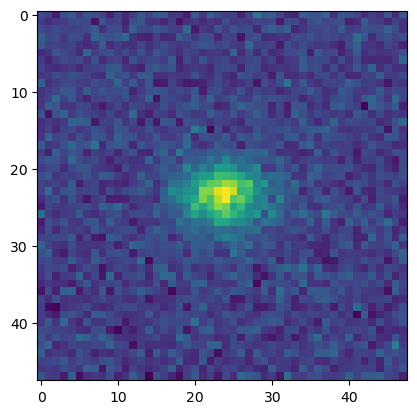

In [12]:
plt.imshow(img)

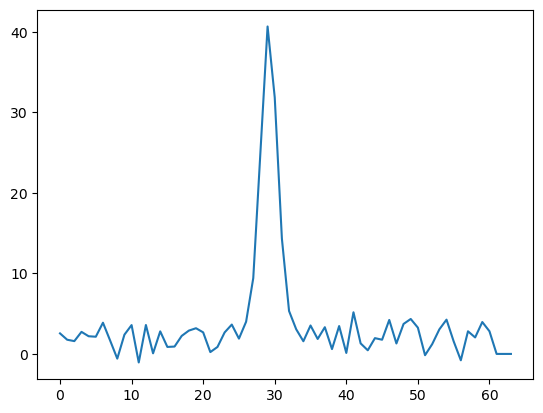

In [13]:
plt.plot(spec[1])